In [3]:
import pandas as pd
import matplotlib.pyplot as plt

1. Look at the BAUS zoning for buildings built in PBA50+ DBP

In [116]:
# new buildings output for PBA50+ DBP
bz = pd.read_csv("M:/urban_modeling/baus/PBA50Plus/PBA50Plus_DraftBlueprint/\
PBA50Plus_Draft_Blueprint_v8_znupd_nodevfix/core_summaries/PBA50Plus_Draft_Blueprint_v8_znupd_nodevfix_new_buildings_summary.csv")

2. Add variables to categorize the parcels' "density type" (rural/suburban/urban-suburban/urban) in order to compare againsst their BAUS zoning

In [117]:
# parcels to jurisdiction crosswalk
pg = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/parcels_geography_2024_02_14.csv")
# jurisdiction to "subregion" crosswalk
juris = pd.read_csv("M:/urban_modeling/baus/juris_subregion.csv")

# make the juris column formats match
juris['jurisdiction'] = juris['jurisdiction'].str.lower().str.replace(' ','_').str.replace('.','')
juris.loc[juris.jurisdiction.str.contains("county"), 'jurisdiction'] = 'unincorporated_' + juris['jurisdiction']
juris['jurisdiction'] = juris['jurisdiction'].str.replace("_county", '')

# parcel to TAZ crosswalk
ptaz = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/2020_08_17_parcel_to_taz1454sub.csv")
# taz to superdistrict crosswalk
taz = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/taz_geography.csv")
# superdistrict to "subregion" crosswalk
sd = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/superdistricts_geography.csv")

In [118]:
# merge the jurisdiction and superdistrict "subregion" variables
bz = bz.merge(pg[['PARCEL_ID', 'juris']], left_on='parcel_id', right_on='PARCEL_ID', how='left')\
              .merge(juris, left_on='juris', right_on='jurisdiction', how='left')

bz = bz.merge(ptaz[['PARCEL_ID', 'ZONE_ID']], left_on='parcel_id', right_on='PARCEL_ID', how='left')\
              .merge(taz[['zone', 'superdistrict']], left_on='ZONE_ID', right_on='zone', how='left')\
              .merge(sd, left_on='superdistrict', right_on='number')

bz = bz.rename(columns={"subregion_x": "subregion_juris", "subregion_y": "subregion_sd"})

3. Add the base zoning to parcels in order to lookup the corresponding zoning input

In [120]:
# latest parcels zoning file
pz = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/zoning/zoning_parcels_2024-04-30.csv")
# latest parcel lookup file
zl = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/zoning/zoning_lookup_2024-04-30.csv")
zl = zl.rename(columns={"name": "zoning_name", "max_dua":"max_dua_zoning", "max_far": "max_far_zoning"})

# merge the zoning lookup to buildings
bz = bz.merge(pz[['PARCEL_ID', 'zoning_id']], left_on='parcel_id', right_on='PARCEL_ID', how='left')\
.merge(zl[['id', 'zoning_name', 'max_dua_zoning', 'max_far_zoning']], left_on='zoning_id', right_on='id', how='left')

4. Look at the BAUS zoning for parcels as compared to their categorized "density type" and lookup the zoning input for any outliers

BAUS zoning processing:
- Apply BAUS zoning processing from imputation- this infers DUA for far/height and FAR from height, but still picks the min
- eliminates zoning on nodev parcels
- applies rural zoning outside of the urban footprint
- sets max dua to be the highest built density in a TAZ, or if there are no buildings max dua = 4

3a. Look at DUA by "density type"

Rural superdistricts are ['Oakland Alameda' 'San Jose CBD' 'Tri Valley' 'West San Jose'
 'Richmond Pinole' 'Solano Remainder' 'Martinez Concord'
 'East Contra Costa' 'Fremont' 'S Ramon Danville' 'Golden Triangle'
 'Palo Alto' 'SE Snta Clara Cnty' 'South San Jose' 'Southern Sonoma'
 'Vallejo Benicia' 'Northern Sonoma' 'Santa Rosa Area' 'S Leandro Hayward'
 'Berkeley Eville' 'Redwood City' 'East San Jose' 'Daly City Millbrae'
 'San Mateo' 'Lamorinda WC' 'Napa City and S' 'Napa Remainder'
 'Southern Marin' 'Northern Marin' 'Central Marin']
They correspont to ['unincorporated_alameda' 'unincorporated_santa_clara'
 'unincorporated_contra_costa' 'unincorporated_solano'
 'unincorporated_sonoma' 'unincorporated_napa' 'unincorporated_marin'
 'unincorporated_san_mateo']
Their distribution of max DUA is AxesSubplot(0.125,0.125;0.775x0.755)


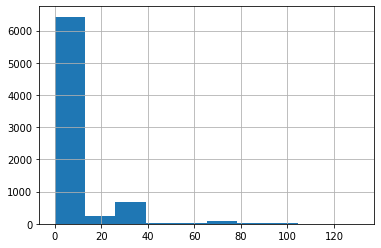

In [136]:
# use jurisdiction-level subregion type since it has greater spatial resolution
rural = bz.loc[bz.subregion_juris == "Unincorporated"]
print("Rural superdistricts are {}".format(rural.name.unique()))
print("They correspont to {}".format(rural.juris.unique()))
print("Their distribution of max DUA is {}".format(rural.max_dua.hist()))

In [179]:
print("Number of rural parcels with DUA > 60 is {}".format(len(rural.loc[rural.max_dua > 60].parcel_id.unique())))
print("This includes {} zoning codes".format(len(rural.loc[rural.max_dua > 60].zoning_name.unique())))
print("Zoning for those parcels is")
rural.loc[rural.max_dua > 60][['zoning_name', 'max_dua','max_dua_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_dua', ascending=False)

Number of rural parcels with DUA > 60 is 77
This includes 34 zoning codes
Zoning for those parcels is


,max_dua,max_dua_zoning
zoning_name,,
M-1_pba40,130.677114,217.800
M-1 (BASIS),100.000000,0.000
MS_pba40,99.900000,99.900
RS:UR (BASIS),99.842155,101.640
P_pba40,87.120000,87.120
R-3/S-1_pba40,87.120000,87.120
R-1/S-73_pba40,87.120000,87.120
Urban-High Density Residential (BASIS),87.100000,87.100
R-1/S-10_pba40,83.489832,104.544


Suburban superdistricts are ['Tri Valley' 'Richmond Pinole' 'Solano Remainder' 'Martinez Concord'
 'East Contra Costa' 'S Ramon Danville' 'SE Snta Clara Cnty'
 'Southern Sonoma' 'Vallejo Benicia' 'Northern Sonoma' 'Santa Rosa Area'
 'San Mateo' 'Lamorinda WC' 'Napa City and S' 'Napa Remainder'
 'Northern Marin']
The correspond to ['dublin' 'livermore' 'pleasanton' 'martinez' 'vacaville' 'fairfield'
 'dixon' 'suisun_city' 'rio_vista' 'concord' 'pleasant_hill' 'pittsburg'
 'clayton' 'lafayette' 'brentwood' 'oakley' 'antioch' 'san_ramon'
 'danville' 'walnut_creek' 'morgan_hill' 'gilroy' 'petaluma'
 'rohnert_park' 'sonoma' 'cotati' 'benicia' 'healdsburg' 'windsor'
 'cloverdale' 'sebastopol' 'santa_rosa' 'half_moon_bay' 'orinda' 'moraga'
 'napa' 'american_canyon' 'calistoga' 'yountville' 'st_helena' 'novato']
Their distribution of max DUA is AxesSubplot(0.125,0.125;0.775x0.755)


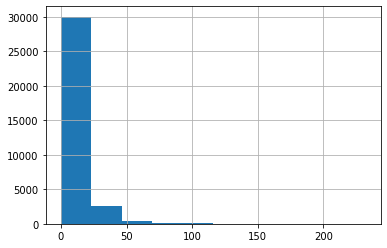

In [144]:
suburban = bz.loc[bz.subregion_juris == 'Inlandcoastaldelta']
print("Suburban superdistricts are {}".format(suburban.name.unique()))
print("The correspond to {}".format(suburban.juris.unique()))
print("Their distribution of max DUA is {}".format(suburban.max_dua.hist()))

In [178]:
print("Number of suburban parcels with DUA > 100 is {}".format(len(suburban.loc[suburban.max_dua > 100].parcel_id.unique())))
print("This includes {} zoning codes".format(len(suburban.loc[suburban.max_dua > 100].zoning_name.unique())))
print("Zoning for those parcels is")
suburban.loc[suburban.max_dua > 100][['zoning_name', 'juris', 'max_dua','max_dua_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_dua', ascending=False)

Number of suburban parcels with DUA > 100 is 9
This includes 4 zoning codes
Zoning for those parcels is


,juris,max_dua,max_dua_zoning
zoning_name,,,
Core Mixed Use (BASIS),santa_rosa,232.00,232.00
Neighborhood Mixed Use (BASIS),santa_rosa,174.00,174.00
RH (HE Data),concord,125.00,125.00
226 - Single Family Low/ Medium Density_pba40,san_ramon,101.64,101.64


Suburban-urban superdistricts are ['Oakland Alameda' 'San Jose CBD' 'West San Jose' 'Richmond Pinole'
 'Fremont' 'SF S SE' 'Golden Triangle' 'Palo Alto' 'Vallejo Benicia'
 'S Leandro Hayward' 'Berkeley Eville' 'Redwood City' 'East San Jose'
 'Daly City Millbrae' 'San Mateo' 'Southern Marin' 'Central Marin']
The correspond to ['alameda' 'piedmont' 'emeryville' 'san_leandro' 'santa_clara' 'campbell'
 'los_gatos' 'cupertino' 'saratoga' 'monte_sereno' 'los_altos' 'richmond'
 'pinole' 'el_cerrito' 'san_pablo' 'hercules' 'union_city' 'fremont'
 'newark' 'daly_city' 'mountain_view' 'sunnyvale' 'milpitas' 'palo_alto'
 'los_altos_hills' 'vallejo' 'hayward' 'berkeley' 'albany' 'menlo_park'
 'redwood_city' 'san_carlos' 'woodside' 'atherton' 'portola_valley'
 'east_palo_alto' 'belmont' 'millbrae' 'brisbane' 'san_bruno' 'pacifica'
 'south_san_francisco' 'burlingame' 'colma' 'san_mateo' 'foster_city'
 'hillsborough' 'corte_madera' 'larkspur' 'mill_valley' 'belvedere'
 'tiburon' 'sausalito' 'san_rafa

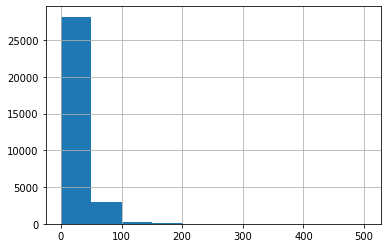

In [158]:
suburbanurban = bz.loc[bz.subregion_juris == 'Bayside']
print("Suburban-urban superdistricts are {}".format(suburbanurban.name.unique()))
print("The correspond to {}".format(suburbanurban.juris.unique()))
print("Their distribution of max DUA is {}".format(suburbanurban.max_dua.hist()))

In [180]:
print("Number of Suburban-urban parcels with DUA > 100 is {}".format(len(suburbanurban.loc[suburbanurban.max_dua > 100].parcel_id.unique())))
print("This includes {} zoning codes".format(len(suburbanurban.loc[suburbanurban.max_dua > 100].zoning_name.unique())))
print("Zoning for those parcels is")
suburbanurban.loc[suburbanurban.max_dua > 100][['zoning_name', 'juris', 'max_dua','max_dua_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_dua', ascending=False)

Number of Suburban-urban parcels with DUA > 100 is 282
This includes 73 zoning codes
Zoning for those parcels is


,juris,max_dua,max_dua_zoning
zoning_name,,,
Mixed Use with Residential (MUR) (HE Data),emeryville,502.000,502.00
C-DMU Core (HE Data),berkeley,418.300,418.30
TN (BASIS),santa_clara,350.000,350.00
C-DMU Outer Core (HE Data),berkeley,345.700,345.70
C-DMU Corridor (HE Data),berkeley,274.800,274.80
...,...,...,...
TOD-2 (HE Data),san_bruno,104.700,104.70
R-2A_pba40,berkeley,101.640,101.64
RHS (BASIS),los_altos_hills,101.640,101.64


Urban superdistricts are ['Oakland Alameda' 'San Jose CBD' 'West San Jose' 'SF NE' 'SF NW'
 'SF S SE' 'Golden Triangle' 'SE Snta Clara Cnty' 'South San Jose'
 'S Leandro Hayward' 'Berkeley Eville' 'SF SW' 'East San Jose'
 'Daly City Millbrae']
The correspond to ['oakland' 'san_jose' 'san_francisco']
Their distribution of max DUA is AxesSubplot(0.125,0.125;0.775x0.755)


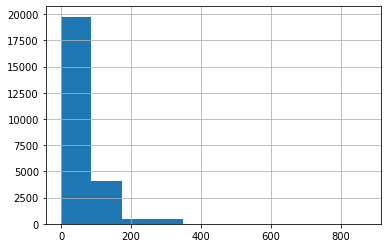

In [160]:
urban = bz.loc[bz.subregion_juris == 'Big Three']
print("Urban superdistricts are {}".format(urban.name.unique()))
print("The correspond to {}".format(urban.juris.unique()))
print("Their distribution of max DUA is {}".format(urban.max_dua.hist()))

In [176]:
print("Number of Urban parcels with DUA > 200 is {}".format(len(urban.loc[urban.max_dua > 200].parcel_id.unique())))
print("This includes {} zoning codes".format(len(urban.loc[urban.max_dua > 250].zoning_name.unique())))
print("Zoning for those parcels is")
urban.loc[urban.max_dua > 200][['zoning_name', 'juris', 'max_dua','max_dua_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_dua', ascending=False)

Number of Urban parcels with DUA > 200 is 683
This includes 29 zoning codes
Zoning for those parcels is


,juris,max_dua,max_dua_zoning
zoning_name,,,
DOWNTOWN- OFFICE-300-S_pba40,san_francisco,871.200000,871.20
Downtown_pba40,san_jose,827.640000,827.64
DC (HE Data),san_jose,800.000000,800.00
DC-NT1 (HE Data),san_jose,800.000000,800.00
CMUO (HE Data),san_francisco,770.764431,875.60
Combined Industrial/Commercial_pba40,san_jose,522.720000,522.72
MUR (HE Data),san_francisco,444.100000,444.10
NCT-FILLMORE (HE Data),san_francisco,437.302424,465.90
D-LM-4 (HE Data),oakland,396.000000,396.00


3b. Look at FAR by "density type"

Rural distribution of max FAR is AxesSubplot(0.125,0.125;0.775x0.755)


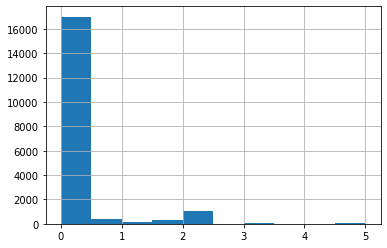

In [70]:
print("Rural distribution of max FAR is {}".format(rural.max_far.hist()))

In [175]:
print("Number of rural parcels with FAR > 3 is {}".format(len(rural.loc[rural.max_far > 3].parcel_id.unique())))
print("This includes {} zoning codes".format(len(rural.loc[rural.max_far > 3].zoning_name.unique())))
print("Zoning for those parcels is")
rural.loc[rural.max_far > 3][['zoning_name', 'juris', 'max_far','max_far_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_far', ascending=False)


Number of rural parcels with FAR > 3 is 24
This includes 14 zoning codes
Zoning for those parcels is


,juris,max_far,max_far_zoning
zoning_name,,,
606 - High Density Residential_pba40,unincorporated_san_mateo,5.000000,NaN
606 - Retail and Office_pba40,unincorporated_san_mateo,5.000000,NaN
M-1 (BASIS),unincorporated_san_mateo,5.000000,0.000000
M-1_pba40,unincorporated_san_mateo,5.000000,5.000000
M-3 (BASIS),unincorporated_contra_costa,5.000000,0.000000
MH_pba40,unincorporated_contra_costa,5.000000,NaN
O (BASIS),unincorporated_solano,5.000000,5.000000
OF (BASIS),unincorporated_contra_costa,5.000000,0.000000
R-LD (BASIS),unincorporated_san_mateo,5.000000,NaN


Suburban distribution of max FAR is AxesSubplot(0.125,0.125;0.775x0.755)


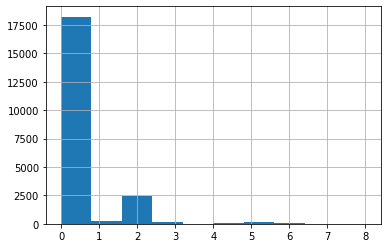

In [84]:
print("Suburban distribution of max FAR is {}".format(suburban.max_far.hist()))

In [174]:
print("Number of suburban parcels with FAR > 4 is {}".format(len(suburban.loc[suburban.max_far > 4].parcel_id.unique())))
print("This includes {} zoning codes".format(len(suburban.loc[suburban.max_far > 4].zoning_name.unique())))
print("Zoning for those parcels is")
suburban.loc[suburban.max_far > 4][['zoning_name', 'juris', 'max_far','max_far_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_far', ascending=False)

Number of suburban parcels with FAR > 4 is 171
This includes 41 zoning codes
Zoning for those parcels is


,juris,max_far,max_far_zoning
zoning_name,,,
Core Mixed Use (BASIS),santa_rosa,8.000000,8.000000
Neighborhood Mixed Use (BASIS),santa_rosa,6.000000,6.000000
DTMU_pba40,concord,6.000000,6.000000
AS (BASIS),walnut_creek,5.000000,0.000000
P-R (BASIS),walnut_creek,5.000000,0.000000
MU-PD (BASIS),walnut_creek,5.000000,0.000000
MU-PD (HE Data),walnut_creek,5.000000,NaN
O-C (BASIS),walnut_creek,5.000000,0.000000
P-D (BASIS),walnut_creek,5.000000,NaN


Suburban-urban distribution of max FAR is AxesSubplot(0.125,0.125;0.775x0.755)


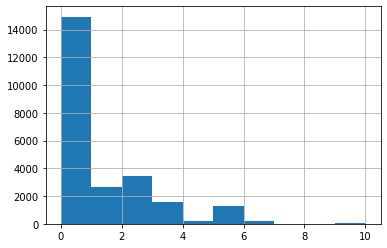

In [78]:
print("Suburban-urban distribution of max FAR is {}".format(suburbanurban.max_far.hist()))

In [172]:
print("Number of suburban-urban parcels with FAR > 6 is {}".format(len(suburbanurban.loc[suburbanurban.max_far > 6].parcel_id.unique())))
print("This includes {} zoning codes".format(len(suburbanurban.loc[suburbanurban.max_far > 6].zoning_name.unique())))
print("Zoning for those parcels is")
suburbanurban.loc[suburbanurban.max_far > 6][['zoning_name', 'juris', 'max_far','max_far_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_far', ascending=False)

Number of suburban-urban parcels with FAR > 6 is 175
This includes 27 zoning codes
Zoning for those parcels is


,juris,max_far,max_far_zoning
zoning_name,,,
MSASP General Commercial-30_pba40,millbrae,10.000000,0.500000
NBMU (BASIS),burlingame,10.000000,2.000000
MSASPD-EIZ (BASIS),millbrae,10.000000,2.000000
MSASP Quasi-Public_pba40,millbrae,10.000000,NaN
MSASP Quasi-Public-30_pba40,millbrae,10.000000,0.300000
606 - Government Facilities_pba40,daly_city,10.000000,NaN
Park and Open Space_pba40,millbrae,10.000000,NaN
DIA (BASIS),millbrae,10.000000,2.666667
R-3 (BASIS),millbrae,10.000000,2.666667


Urban distribution of max FAR is AxesSubplot(0.125,0.125;0.775x0.755)


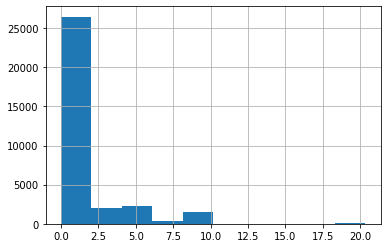

In [81]:
print("Urban distribution of max FAR is {}".format(urban.max_far.hist()))

In [173]:
print("Number of Urban parcels with FAR > 10 is {}".format(len(urban.loc[urban.max_far > 10].parcel_id.unique())))
print("This includes {} zoning codes".format(len(urban.loc[urban.max_far > 10].zoning_name.unique())))
print("Zoning for those parcels is")
urban.loc[urban.max_far > 10][['zoning_name', 'juris', 'max_far','max_far_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_far', ascending=False)

Number of Urban parcels with FAR > 10 is 47
This includes 9 zoning codes
Zoning for those parcels is


,juris,max_far,max_far_zoning
zoning_name,,,
Downtown_pba40,san_jose,20.333333,30.000000
Central Business District_pba40,oakland,20.000000,20.000000
DOWNTOWN- OFFICE-300-S_pba40,san_francisco,20.000000,20.000000
D-LM-4 (BASIS),oakland,18.333333,18.333333
240' Height Allowed (HE Data),san_francisco,11.090645,NaN
Combined Industrial/Commercial_pba40,san_jose,11.000000,12.000000
Transit Residential_pba40,san_jose,11.000000,12.000000
S-15 (BASIS),oakland,10.666667,10.666667
S-15W (BASIS),oakland,10.283830,10.666667
